In [1]:
%matplotlib notebook
from utils.dataloader import PascalVOCDataset
from utils.dataloader import myimshow
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
import numpy as np
from matplotlib import pyplot as plt
from utils.PositionSensitiveScoreMap import PositionSensitiveScoreMap

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
# dataset_root_dir = "/datasets/ee285f-public/PascalVOC2012/"
dataset_root_dir = "../Datasets/VOCtrainval_11-May-2012/VOCdevkit/VOC2012"

#Creating training and validation sets. Go to utils/dataloader.py for info on important PascalVOCDataset arguments & attributes
train_set = PascalVOCDataset(dataset_root_dir, mode= 'train')
test_set = PascalVOCDataset(dataset_root_dir, mode= 'val')

#Create dataloaders
B = 1
train_loader = td.DataLoader(train_set, batch_size = B, pin_memory = True, shuffle = True)
test_loader = td.DataLoader(test_set, batch_size = B, pin_memory = True)

<IPython.core.display.Javascript object>


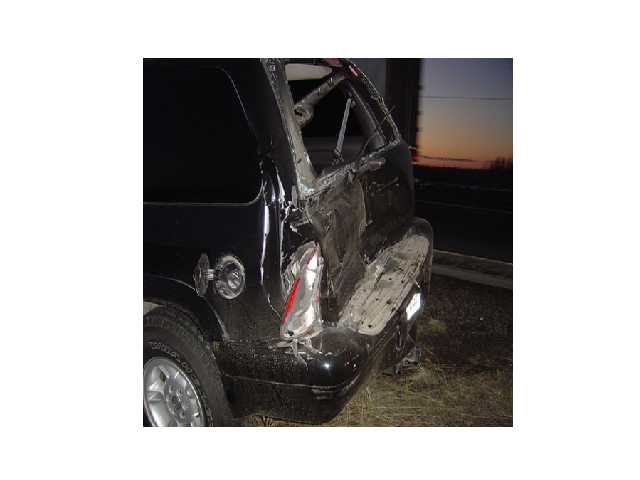

Bounding box corners tensor([[  1,   1, 520, 410]], dtype=torch.int32)


In [3]:
#Training set image demo
fig, ax = plt.subplots()
x, bbox, bbox_labels, scale = train_set.__getitem__(15)
h = myimshow(x, ax)

print("Bounding box corners", bbox)

In [4]:
tensor_im = x.to(device).unsqueeze(0)

In [5]:
#before running, $cd Multi-Object-Detection/model/utils/nms
#then            $python3 build.py build_ext --inplace

from model.region_proposal_network import RegionProposalNetwork
from model.resnet101extractor import Resnet101Extractor
from model.rfcn_resnet101 import Resnet101RoIHead
from model.rfcn_resnet101 import RFCNResnet101

n_fg_class = 20
feat_stride = 520//16
extractor = Resnet101Extractor().to(device)
rpn = RegionProposalNetwork(in_channels=1024, mid_channels = 1024).to(device)
head = Resnet101RoIHead( #Main class to change
            n_class=n_fg_class + 1,
            roi_size=7,
            spatial_scale=(1. / feat_stride)
        ).to(device)

rfcn = RFCNResnet101().to(device)

C:\Users\prvo\Documents\Multi-Object-Detection\model\utils\nms\non_maximum_suppression.py:12: UserWarning: 
    the python code for non_maximum_suppression is about 2x slow
    It is strongly recommended to build cython code: 
    `cd model/utils/nms/; python3 build.py build_ext --inplace
  `cd model/utils/nms/; python3 build.py build_ext --inplace''')
C:\Users\prvo\Documents\Multi-Object-Detection\model\rfcn_resnet101.py:83: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.cls_layer.weight.data, 0.0, 0.01)
C:\Users\prvo\Documents\Multi-Object-Detection\model\rfcn_resnet101.py:87: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(self.reg_layer.weight.data, 0.0, 0.01)


In [6]:
out = rfcn(tensor_im)

C:\Users\prvo\Documents\Multi-Object-Detection\utils\PositionSensitiveScoreMap_V2.py:61: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(F.adaptive_avg_pool2d(pooling_track.float(),(1,1))[:,:])


In [7]:
from trainer import FasterRCNNTrainer
trainer = FasterRCNNTrainer(rfcn).to(device)

Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "C:\Users\prvo\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "C:\Users\prvo\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\util\connection.py", line 80, in create_connection
    raise err
  File "C:\Users\prvo\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\util\connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\prvo\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "C:\Users\prvo\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 354, in _mak

In [8]:
train_loader = td.DataLoader(train_set, batch_size=1, pin_memory = True, shuffle = True)
test_loader  = td.DataLoader(test_set, batch_size=1, pin_memory = True, shuffle = False)

In [22]:
import time
t = time.time()
img, bboxes, lbls, scale = next(iter(train_loader))
img = img.to(device)
bboxes = bboxes.to(device)
lbls = lbls.to(device)
scale = scale.item()
loss =trainer.train_step(img, bboxes, lbls, scale)
elapsed = time.time() - t
print("Elapsed time: ", elapsed)
print("Loss tuple: ", loss)

Elapsed time:  38.66900038719177
Loss tuple:  LossTuple(rpn_loc_loss=tensor(20.1583, device='cuda:0', grad_fn=<CopyBackwards>), rpn_cls_loss=tensor(76.8172, device='cuda:0', grad_fn=<NllLossBackward>), roi_loc_loss=tensor(142.2020, device='cuda:0', grad_fn=<CopyBackwards>), roi_cls_loss=tensor(2.3540, device='cuda:0', grad_fn=<NllLossBackward>), total_loss=tensor(241.5314, device='cuda:0', grad_fn=<AddBackward0>))


In [11]:
feature_map = extractor(tensor_im)
rpn_locs, rpn_scores, rois, roi_indices, anchor = rpn.forward(feature_map,(520,520))
#print(rois)
#rpn_locs, rpn_scores, rois, roi_indices, anchor = rpn.forward(feature_map,feature_map.shape[2:])
#print(rois)
cls_layer = nn.Conv2d(1024,21*7*7, [1,1], padding=0, stride=1).cuda()
#nn.init.kaiming_normal_(cls_layer.weight.data)

cls_conv_out = cls_layer(feature_map)
PSSM =PositionSensitiveScoreMap()
#print(PSSM)
scores = PSSM(cls_conv_out,rois)
print(rois.shape[0])
print(scores.sum(2))

C:\Users\prvo\Documents\Multi-Object-Detection\utils\PositionSensitiveScoreMap.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  scores = self.softmax(self.AvgPool(pooling_track.float()))


58
tensor([[[1.4685e-02],
         [2.9849e-05],
         [3.5102e-03],
         ...,
         [1.7993e-02],
         [8.0547e-01],
         [1.8000e-02]],

        [[5.2887e-04],
         [1.8381e-03],
         [5.9491e-04],
         ...,
         [7.0184e-01],
         [1.4634e-02],
         [3.7947e-03]],

        [[4.7619e-02],
         [4.7619e-02],
         [4.7619e-02],
         ...,
         [4.7619e-02],
         [4.7619e-02],
         [4.7619e-02]],

        ...,

        [[4.7619e-02],
         [4.7619e-02],
         [4.7619e-02],
         ...,
         [4.7619e-02],
         [4.7619e-02],
         [4.7619e-02]],

        [[4.7619e-02],
         [4.7619e-02],
         [4.7619e-02],
         ...,
         [4.7619e-02],
         [4.7619e-02],
         [4.7619e-02]],

        [[4.7619e-02],
         [4.7619e-02],
         [4.7619e-02],
         ...,
         [4.7619e-02],
         [4.7619e-02],
         [4.7619e-02]]], grad_fn=<SumBackward2>)


In [12]:
rfcn.cuda()

RFCNResnet101(
  (extractor): Resnet101Extractor(
    (RN_base): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (3): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (downsample): Se

In [5]:
import os
os.getcwd()

'C:\\Users\\prvo\\Documents\\Multi-Object-Detection'

In [21]:
a=np.array([5,0,0,0,0])

In [26]:
(a>0).astype('int32')

array([1, 0, 0, 0, 0])

In [14]:
from __future__ import  absolute_import
# though cupy is not used but without this line, it raise errors...
import cupy as cp
import os

import ipdb
import matplotlib
from tqdm import tqdm

from utils.config import opt
from data.dataset import Dataset, TestDataset, inverse_normalize
from model import FasterRCNNVGG16
from torch.utils import data as data_
from trainer import FasterRCNNTrainer
from utils import array_tool as at
from utils.vis_tool import visdom_bbox
from utils.eval_tool import eval_detection_voc

# fix for ulimit
# https://github.com/pytorch/pytorch/issues/973#issuecomment-346405667
import resource

rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (20480, rlimit[1]))

matplotlib.use('agg')


def eval(dataloader, faster_rcnn, test_num=10000):
    pred_bboxes, pred_labels, pred_scores = list(), list(), list()
    gt_bboxes, gt_labels, gt_difficults = list(), list(), list()
    for ii, (imgs, sizes, gt_bboxes_, gt_labels_, gt_difficults_) in tqdm(enumerate(dataloader)):
        sizes = [sizes[0][0].item(), sizes[1][0].item()]
        pred_bboxes_, pred_labels_, pred_scores_ = faster_rcnn.predict(imgs, [sizes])
        gt_bboxes += list(gt_bboxes_.numpy())
        gt_labels += list(gt_labels_.numpy())
        gt_difficults += list(gt_difficults_.numpy())
        pred_bboxes += pred_bboxes_
        pred_labels += pred_labels_
        pred_scores += pred_scores_
        if ii == test_num: break

    result = eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        use_07_metric=True)
    return result


def train(**kwargs):
    opt._parse(kwargs)

    dataset = Dataset(opt)
    print('load data')
    dataloader = data_.DataLoader(dataset, \
                                  batch_size=1, \
                                  shuffle=True, \
                                  # pin_memory=True,
                                  num_workers=opt.num_workers)
    testset = TestDataset(opt)
    test_dataloader = data_.DataLoader(testset,
                                       batch_size=1,
                                       num_workers=opt.test_num_workers,
                                       shuffle=False, \
                                       pin_memory=True
                                       )
    faster_rcnn = FasterRCNNVGG16()
    print('model construct completed')
    trainer = FasterRCNNTrainer(faster_rcnn).cuda()
    if opt.load_path:
        trainer.load(opt.load_path)
        print('load pretrained model from %s' % opt.load_path)
    trainer.vis.text(dataset.db.label_names, win='labels')
    best_map = 0
    lr_ = opt.lr
    for epoch in range(opt.epoch):
        trainer.reset_meters()
        for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader)):
            scale = at.scalar(scale)
            img, bbox, label = img.cuda().float(), bbox_.cuda(), label_.cuda()
            trainer.train_step(img, bbox, label, scale)

            if (ii + 1) % opt.plot_every == 0:


                # plot loss
                trainer.vis.plot_many(trainer.get_meter_data())

                # plot groud truth bboxes
                ori_img_ = inverse_normalize(at.tonumpy(img[0]))
                gt_img = visdom_bbox(ori_img_,
                                     at.tonumpy(bbox_[0]),
                                     at.tonumpy(label_[0]))
                trainer.vis.img('gt_img', gt_img)

                # plot predicti bboxes
                _bboxes, _labels, _scores = trainer.faster_rcnn.predict([ori_img_], visualize=True)
                pred_img = visdom_bbox(ori_img_,
                                       at.tonumpy(_bboxes[0]),
                                       at.tonumpy(_labels[0]).reshape(-1),
                                       at.tonumpy(_scores[0]))
                trainer.vis.img('pred_img', pred_img)

                # rpn confusion matrix(meter)
                trainer.vis.text(str(trainer.rpn_cm.value().tolist()), win='rpn_cm')
                # roi confusion matrix
                trainer.vis.img('roi_cm', at.totensor(trainer.roi_cm.conf, False).float())
        eval_result = eval(test_dataloader, faster_rcnn, test_num=opt.test_num)
        trainer.vis.plot('test_map', eval_result['map'])
        lr_ = trainer.faster_rcnn.optimizer.param_groups[0]['lr']
        log_info = 'lr:{}, map:{},loss:{}'.format(str(lr_),
                                                  str(eval_result['map']),
                                                  str(trainer.get_meter_data()))
        trainer.vis.log(log_info)

        if eval_result['map'] > best_map:
            best_map = eval_result['map']
            best_path = trainer.save(best_map=best_map)
        if epoch == 9:
            trainer.load(best_path)
            trainer.faster_rcnn.scale_lr(opt.lr_decay)
            lr_ = lr_ * opt.lr_decay

        if epoch == 13: 
            break



ModuleNotFoundError: No module named 'ipdb'